<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Nov 28 13:59:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    30W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.0


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

to prevent underfitting:
* add more layers to the model to give the model more ways to learn from the data.
* Add more data.
* Add less regularization.
* Train for more epochs.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = Path(data_path / "pizza_steak_sushi")

# Download the data if it doesnt exist else skipp download
if image_path.is_dir():
    print(f"{image_path } already exists.. skipping download...." )
else:
    print(f"Did not find {image_path}, Preparing to download")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request  = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading the data")
        f.write(request.content)

    # unzip the data
    with zipfile.ZipFile(data_path /"pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"Unzipping data")
        zip_ref.extractall(image_path)


data\pizza_steak_sushi already exists.. skipping download....


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

    walk_through_dir(image_path)

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\steak\673127.jpg
Class name of the image: steak
Size of the image is: (512, 512)


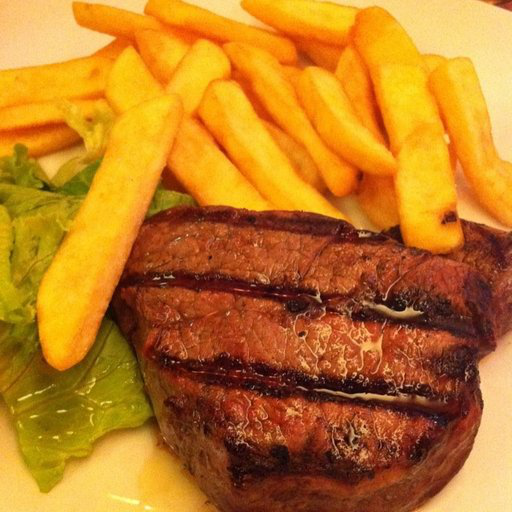

In [6]:
# Visualize an
import random
from PIL import Image

# random.seed(42)

# Get all  image paths as a list
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Randomly select an image path from the list
random_img_path = random.choice(image_path_list)

# Get class name from the image path
class_name = random_img_path.parent.stem

# Display the image
img = Image.open(random_img_path)

# Display some attributes
print(f"Random image path: {random_img_path}")
print(f"Class name of the image: {class_name}")
print(f"Size of the image is: {img.height, img.width}")
img

Shape of the image: (512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

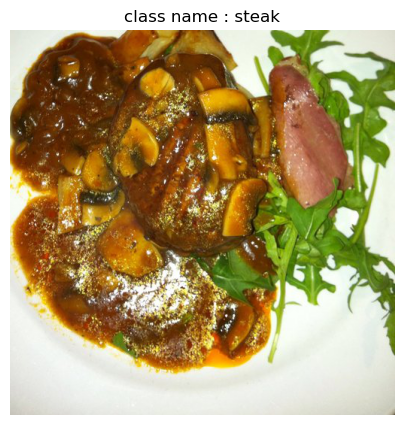

In [7]:
# Do the image visualization with matplotlib

import random
import matplotlib.pyplot as plt
import numpy as np

image_path_list = list(image_path.glob("*/*/*.jpg"))

# select a random image and get the class name from the image
random_img_path = random.choice(image_path_list)
class_name = random_img_path.parent.stem

# Convert the  image to an array
img = Image.open(random_img_path)
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f"class name : {class_name}")
print(f"Shape of the image: {img_as_array.shape}")
plt.axis('off')

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

### 3.1 Transforming data with torchvision.transforms


In [8]:
from torchvision import transforms

In [9]:
# Write transform for turning images into tensors
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])
simple_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [10]:
simple_transform(img).shape

torch.Size([3, 64, 64])

Shape after transform: torch.Size([3, 64, 64])


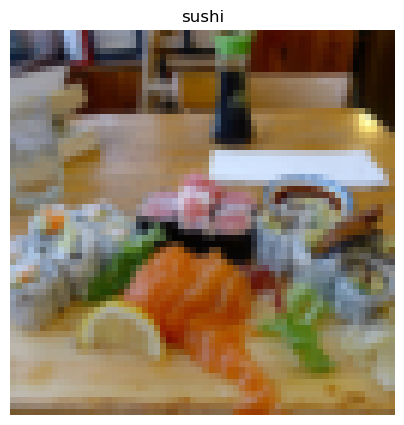

In [11]:
# Write a function to plot transformed images
def plot_transformed_image(transform, img_path):
    """ This function takes in path of an image and plots the image through our transformation"""
    img = Image.open(img_path)
    transformed_img = transform(img)


    # Plot the image using matplotlib
    plt.figure(figsize=(5, 5))
    print(f"Shape after transform: {transformed_img.shape}")
    plt.imshow(transformed_img.permute(1, 2, 0))
    plt.title(img_path.parent.stem)
    plt.axis("off")

random_img = random.choice(image_path_list)
plot_transformed_image(simple_transform, random_img)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                            transform=simple_transform,
                            target_transform=None)

test_data = ImageFolder(root=test_dir,
                           transform=simple_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers = NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x141320bebc0>,
 <torch.utils.data.dataloader.DataLoader at 0x141320bfee0>)

In [17]:
# How many batches of images are in our data loaders?
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test dataloader: {len(test_dataloader)}")

Number of batches in train_dataloader: 8
Number of batches in test dataloader: 3


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*16*hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# Create a model and instantiate it
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

In [19]:
# Get the in_features of linear model
model_0(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.0074, -0.0618,  0.0066]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [20]:
from torchinfo import summary

summary(model_0, input_size=([1, 3, 64, 64]))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
 
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss+=loss
    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch , (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss

      # Calculate and accumulate accuracy
      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc+=(test_pred_class==y).sum().item()/len(test_pred)

    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /=len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [24]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

model_0_results_5_epochs = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2500 | test_loss: 1.1038 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0739 | train_acc: 0.4258 | test_loss: 1.1352 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0716 | train_acc: 0.4258 | test_loss: 1.1677 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1152 | train_acc: 0.3047 | test_loss: 1.1502 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0664 | train_acc: 0.4258 | test_loss: 1.1355 | test_acc: 0.2812


{'train_loss': [tensor(1.1078, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0739, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0716, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1152, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0664, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [tensor(1.1038, device='cuda:0'),
  tensor(1.1352, device='cuda:0'),
  tensor(1.1677, device='cuda:0'),
  tensor(1.1502, device='cuda:0'),
  tensor(1.1355, device='cuda:0')],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.28125]}

In [25]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

model_0_results_20_epochs = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0237 | train_acc: 0.4805 | test_loss: 1.0858 | test_acc: 0.2708
Epoch: 2 | train_loss: 0.9761 | train_acc: 0.4688 | test_loss: 1.0919 | test_acc: 0.2812
Epoch: 3 | train_loss: 0.9123 | train_acc: 0.5820 | test_loss: 1.1360 | test_acc: 0.2812
Epoch: 4 | train_loss: 0.9079 | train_acc: 0.6133 | test_loss: 1.1330 | test_acc: 0.3011
Epoch: 5 | train_loss: 0.8278 | train_acc: 0.6055 | test_loss: 1.0741 | test_acc: 0.3826
Epoch: 6 | train_loss: 1.0043 | train_acc: 0.5156 | test_loss: 1.0063 | test_acc: 0.4025
Epoch: 7 | train_loss: 0.7682 | train_acc: 0.6445 | test_loss: 1.1052 | test_acc: 0.3826
Epoch: 8 | train_loss: 0.8232 | train_acc: 0.6797 | test_loss: 1.0586 | test_acc: 0.3627
Epoch: 9 | train_loss: 0.9109 | train_acc: 0.5039 | test_loss: 1.0006 | test_acc: 0.4441
Epoch: 10 | train_loss: 0.8636 | train_acc: 0.5117 | test_loss: 0.9665 | test_acc: 0.5331
Epoch: 11 | train_loss: 0.7689 | train_acc: 0.6719 | test_loss: 1.0353 | test_acc: 0.3428
Epoch: 12 | train_l

{'train_loss': [tensor(1.0237, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9761, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9123, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9079, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8278, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0043, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7682, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8232, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9109, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8636, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7689, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8179, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7241, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1511, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7402, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7646, device='cuda:0', grad_fn=

In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

model_0_results_50_epochs = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6783 | train_acc: 0.7422 | test_loss: 1.1634 | test_acc: 0.3532
Epoch: 2 | train_loss: 0.7575 | train_acc: 0.5859 | test_loss: 1.0571 | test_acc: 0.4148
Epoch: 3 | train_loss: 0.6348 | train_acc: 0.7266 | test_loss: 1.1132 | test_acc: 0.3845
Epoch: 4 | train_loss: 0.6189 | train_acc: 0.7500 | test_loss: 1.0824 | test_acc: 0.3741
Epoch: 5 | train_loss: 0.5778 | train_acc: 0.7578 | test_loss: 1.0652 | test_acc: 0.4441
Epoch: 6 | train_loss: 0.7387 | train_acc: 0.6484 | test_loss: 1.1086 | test_acc: 0.4441
Epoch: 7 | train_loss: 0.5520 | train_acc: 0.7891 | test_loss: 1.1966 | test_acc: 0.3741
Epoch: 8 | train_loss: 0.6144 | train_acc: 0.7812 | test_loss: 1.1503 | test_acc: 0.4148
Epoch: 9 | train_loss: 0.6867 | train_acc: 0.6250 | test_loss: 1.2189 | test_acc: 0.3835
Epoch: 10 | train_loss: 0.6421 | train_acc: 0.7695 | test_loss: 1.0524 | test_acc: 0.4943
Epoch: 11 | train_loss: 0.5723 | train_acc: 0.7578 | test_loss: 1.1954 | test_acc: 0.3741
Epoch: 12 | train_l

KeyboardInterrupt: 

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

model_1_results_20_epochs = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20)
model_1_results_20_epochs

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root=train_data_20_percent_path,
                                    transform=simple_transform,
                                    target_transform=None)

test_data_20_percent = ImageFolder(root=test_data_20_percent_path,
                                        transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)

train_dataloader_20_percent, test_dataloader_20_percent

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?